# Outlier Detection Using Unsupervised Machine Learning

Common machine learning based unsupervised outlier detection techniques are
* Detecting outliers using Unsupervised KNN
* Detecting outliers using LOF (Local outlier Factor)
* Detecting outliers using iForest (Isolation Forests)
* Detecting outliers using One-Class Support Vector Machine (OCSVM)
* Detecting outliers using COPOD (Copula-Based Outlier Detection)
* Detecting outliers with PyCaret

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import pyod
import statsmodels
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
statsmodels -> {statsmodels.__version__}

''')




Matplotlib -> 3.5.2
pandas -> 1.4.4   
statsmodels -> 0.13.2




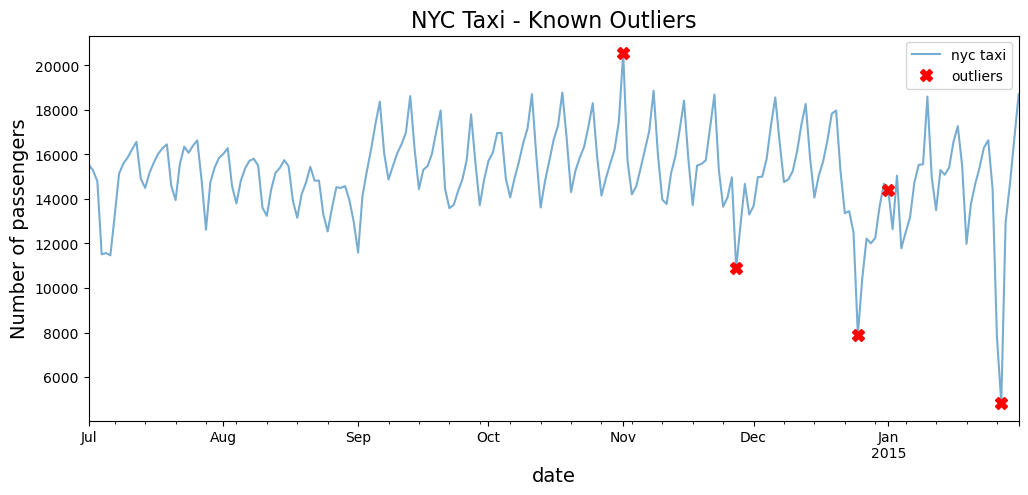

In [4]:
file = r'./CodeAndDatasets/datasets/Ch14/nyc_taxi.csv'

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)


def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'top',
                 labels=False,
                 name=None):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX', markersize=9)
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('Number of passengers')
    plt.legend(['nyc taxi','outliers'])
    # if name:
    #     plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch14/images/{name}.png', bbox_inches='tight', dpi=600)
    plt.show()


nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

plot_outliers(known_outliers, tx, 'Known Outliers', name='fig14.1')

### Detecting Outliers using K-Nearest Neighbors

Unsupervised KNN algorithm, finds the closest K nearest neighbors for every data point and measures the average distance. The points with the most significant distance from the population will be considered outliers.
distance becomes the score to determine which points are outliers among the population, and hence KNN is a proximity-based algorithm.

important parameters in pyod KNN:

contamination -> numeric(float) -> value representing the dataset's fraction of outliers.

method -> largest or mean or median. 
        • largest uses the largest distance to the kth neighbor as the outlier score.
        • mean uses the average of the distances to the k neighbors as the outlier score.
        • median uses the median of the distances to the k neighbors as the outlier score

metric -> metric to compute distances -> minkowski distance (the p-norm distance) and can take any distance metric from scikit-learn or scipy libraries like euclidean (l1) or manhattan (l2)

n_neighbours 

Number of outliers =  6
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


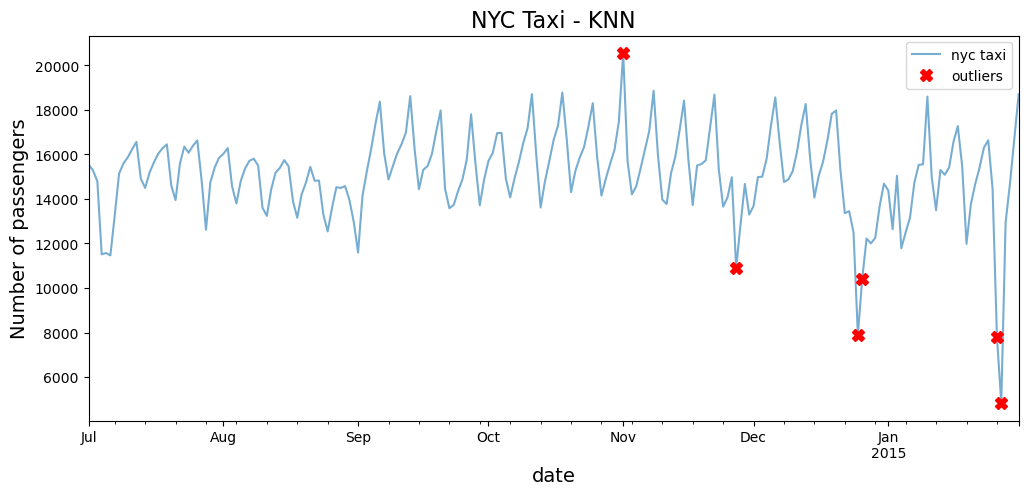

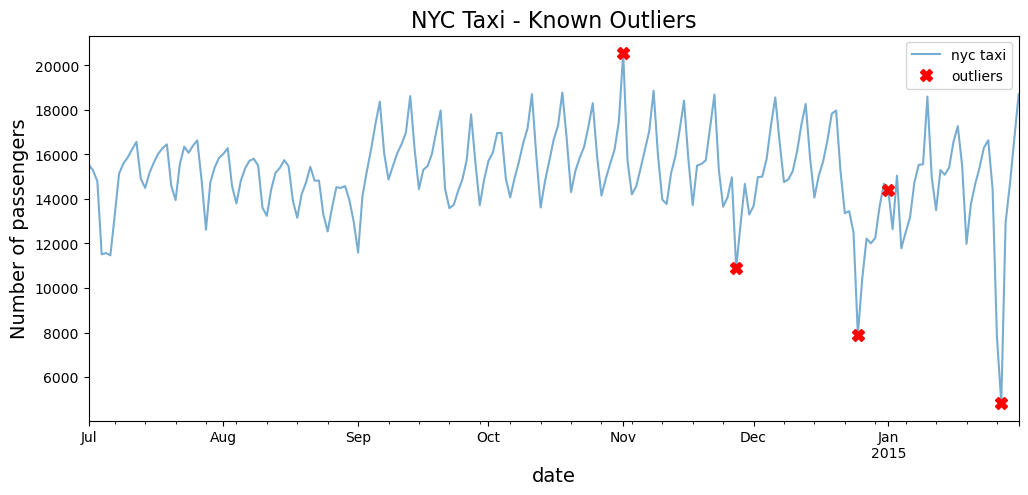

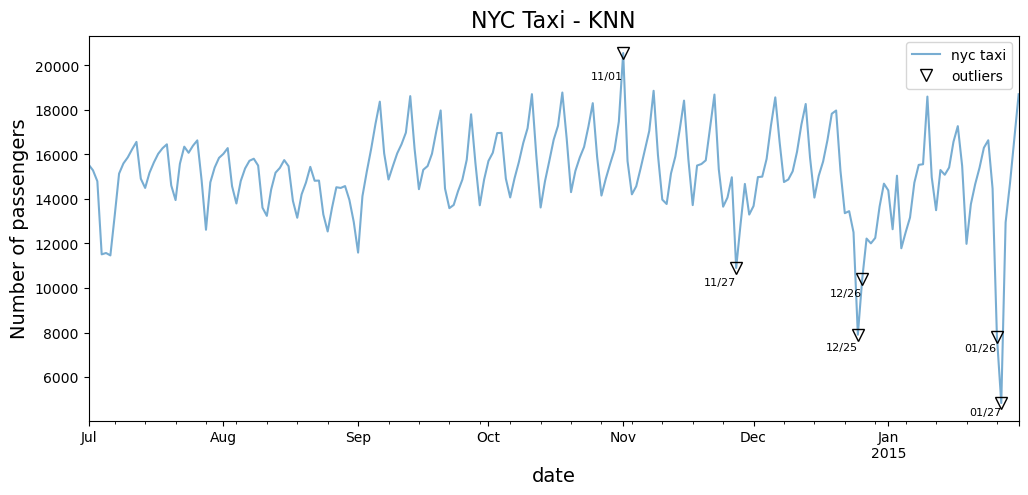

In [8]:
from pyod.models.knn import KNN

knn = KNN(contamination=0.03, # 0.03 represents 3% of dataset values to be outliers
                              # you can experiment and get the value
          method='mean',
          n_neighbors=5)

knn.fit(tx)

predicted = pd.Series(knn.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

print(tx.loc[nyc_dates])

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
print(outliers)

plot_outliers(outliers, tx, 'KNN',  name='fig14.2')


plot_outliers(known_outliers, tx, 'Known Outliers')

plot_outliers(outliers, tx, 'KNN', labels=True)

In [9]:
## decision_scores_ to get the scores of the observations

knn_scores = knn.decision_scores_
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False)

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000
2014-09-27,225.604167


In [10]:
n = int(len(tx)*0.03)
knn_scores_df.nlargest(n, 'score')

,score
timestamp,
2015-01-27,4862.058333
2015-01-26,2474.508333
2014-12-25,2441.250000
2014-11-01,1806.850000
2014-12-26,1009.616667
2014-11-27,608.250000


In [11]:
## predict_prob returns the probability of being normal and the 
# probability of being abnormal for each observation.
# PyOD provides two methods to determe these percentages: linear or unify
# two methods scale the outlier scores before calculating the probabilities.


# In the case of linear, the implementation uses MinMaxScaler.
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))

print(knn_proba_df.nlargest(n, 'Proba_Anomaly'))

# The unify method uses the z-score(standardization) and Gaussian error function (erf)
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly'))



            Proba_Normal  Proba_Anomaly
timestamp                              
2015-01-27        27.337         72.663
2015-01-26        64.256         35.744
2014-12-25        64.599         35.401
2014-11-01        70.682         29.318
2014-12-26        84.341         15.659
2014-11-27        90.548          9.452
            Proba_Normal  Proba_Anomaly
timestamp                              
2015-01-27         0.000        100.000
2015-01-26         0.012         99.988
2014-12-25         0.014         99.986
2014-11-01         0.189         99.811
2014-12-26        12.225         87.775
2014-11-27        40.330         59.670


In [ ]:
## to save and load pyod models

# from joblib import dump, load

# # save the model
# dump(knn, 'knn_outliers.joblib')
# # load the model
# knn = load('knn_outliers.joblib')

In [12]:
## function to use different methods, contamination, k values to experiment
def knn_anomaly(df, method='mean', contamination=0.05, k=5):
    knn = KNN(contamination=contamination,
              method=method,
              n_neighbors=5)
    knn.fit(df)
    
    decision_score = pd.DataFrame(knn.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, knn.threshold_

for method in ['mean', 'median', 'largest']:
    o, t = knn_anomaly(tx, method=method)
    print(f'Method= {method}, Threshold= {t}')
    print(o)

'''Notice the top six (represent the 3% contamination) are identical 
for all three methods. The order may vary and the decision scores are 
different between the methods. '''

Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

### Detecting Outliers Using Local Outlier Factor LOF

KNN is good for finding GLobal outlires, but not able to identify local outliers.

LOF uses density rather than distance for scoring points and detecting outliers. so, LOF is considered as density-based algorithm

The LOF is a density-based algorithm that assumes that outlier points are more isolated and have lower local density scores compared to their neighbors.


In [13]:
from pyod.models.lof import LOF

lof = LOF(contamination=0.03, n_neighbors=5)

lof.fit(tx)

# The predict method will output either 1 or 0 for each data point. 
# A value of 1 indicates an outlier
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

tx.loc[nyc_dates]

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

print(lof.threshold_)

lof_scores = lof.decision_scores_
lof_scores_df = (pd.DataFrame(lof_scores, 
             index=tx.index, 
             columns=['score']))
lof_scores_df[lof_scores_df['score'] >= lof.threshold_].sort_values('score', ascending=False)


Number of outliers =  6
1.7717390813973128


,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571
2015-01-12,1.796124


In [14]:
n = int(len(tx)*0.03)
lof_scores_df.nlargest(n, 'score')

,score
timestamp,
2014-11-01,14.254309
2015-01-27,5.270860
2015-01-26,3.988552
2014-12-25,3.952827
2014-12-26,2.295987
2014-10-31,2.158571


            Proba_Normal  Proba_Anomaly
timestamp                              
2014-10-31        92.361          7.639
2014-11-01        22.033         77.967
2014-12-25        89.121         10.879
2014-12-26        91.625          8.375
2015-01-26        88.972         11.028
2015-01-27        83.610         16.390
            Proba_Normal  Proba_Anomaly
timestamp                              
2014-10-31        47.955         52.045
2014-11-01         0.000        100.000
2014-12-25        25.309         74.691
2014-12-26        42.020         57.980
2015-01-26        24.484         75.516
2015-01-27         5.954         94.046


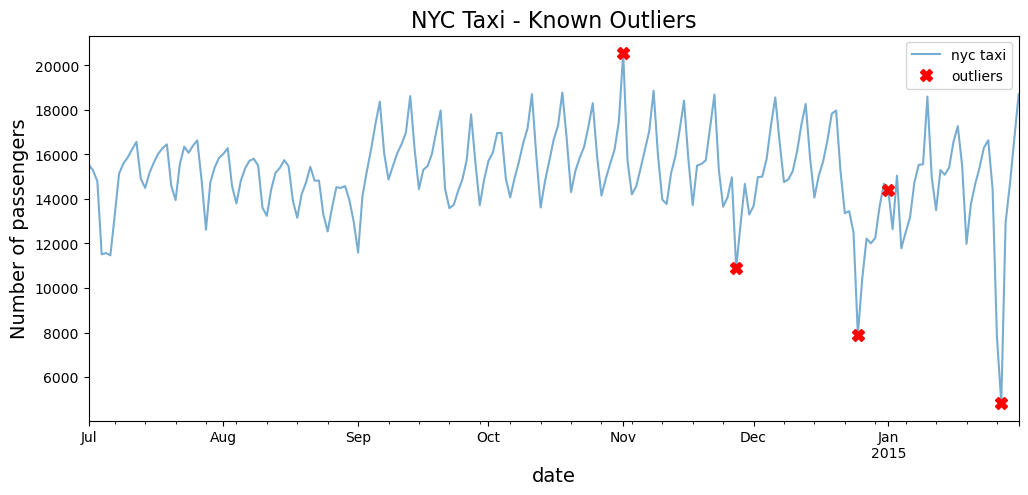

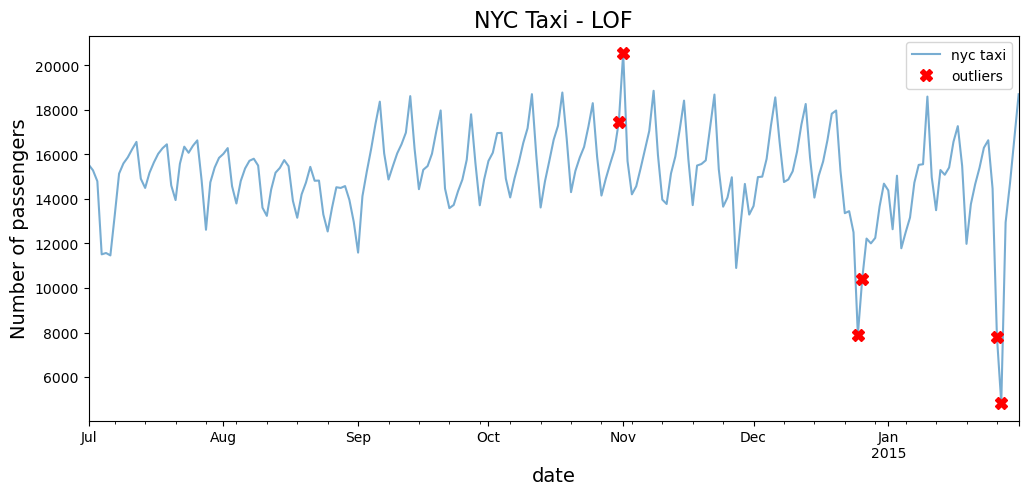

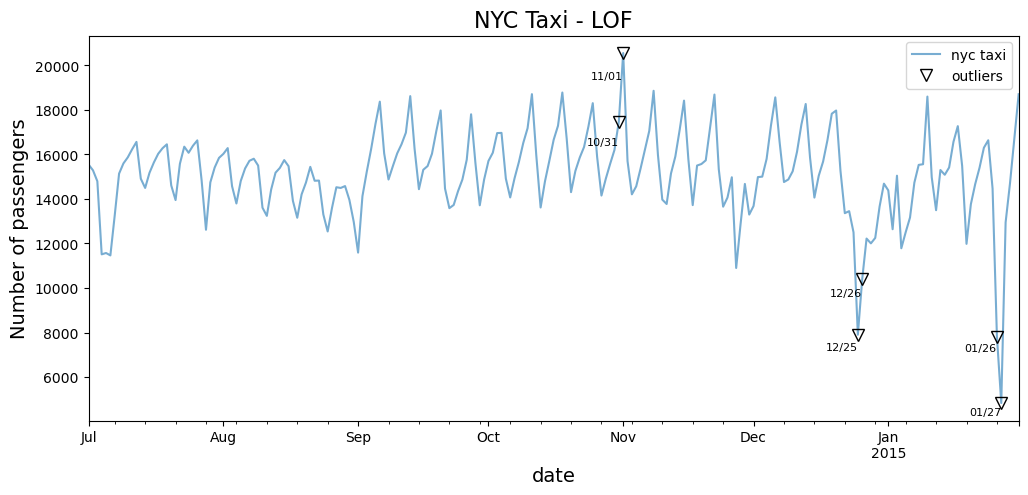

In [16]:
lof_proba = lof.predict_proba(tx, method='linear')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
print(lof_proba_df[:n].sort_index())



lof_proba = lof.predict_proba(tx, method='unify')
lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])
            .sort_values('Proba_Anomaly',
                        ascending=False)
               )
print(lof_proba_df[:n].sort_index())

plot_outliers(known_outliers, tx, 'Known Outliers')

plot_outliers(outliers, tx, 'LOF', name='fig14.4')

plot_outliers(outliers, tx, 'LOF', labels=True)

### Cluster Based Local Outlier factor

The CBLOF is similar to LOF in concept as it relies on cluster size and 
distance when calculating the scores to determine outliers. So, instead of the number of neighbors (n_neighbors like in LOF), we now have a new parameter, which is the number of clusters (n_clusters).

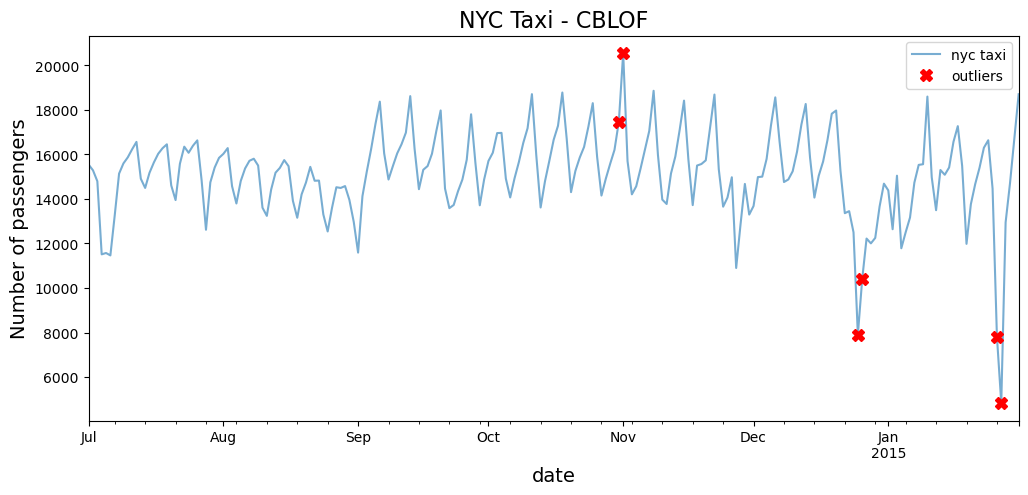

In [17]:
from pyod.models.cblof import CBLOF
cblof = CBLOF(n_clusters=4, contamination=0.03)
cblof.fit(tx)
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
plot_outliers(outliers, tx, 'CBLOF', name='fig14.5')

### Detecting Outliers using Isolation Forests


Random Forests is a tree-based supervised learning algorithm (Ensemble learning is the concept of multiple weak learners collaborating to produce an optimal solution). Isolation Forests is similar to Random Forests.

The number of partitions required to isolate an anomaly is typically smaller than the number of partitions needed to isolate a regular point as Anomaly point is further from other points and thus easier to seperate.

So, iForest algo isolates anomalies by randomly partitioning a dataset into multiple partitions. the splits are like decision paths and the shorter the path length to a point, the higher the chances of an anomaly.


Number of outliers =  7
                   value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


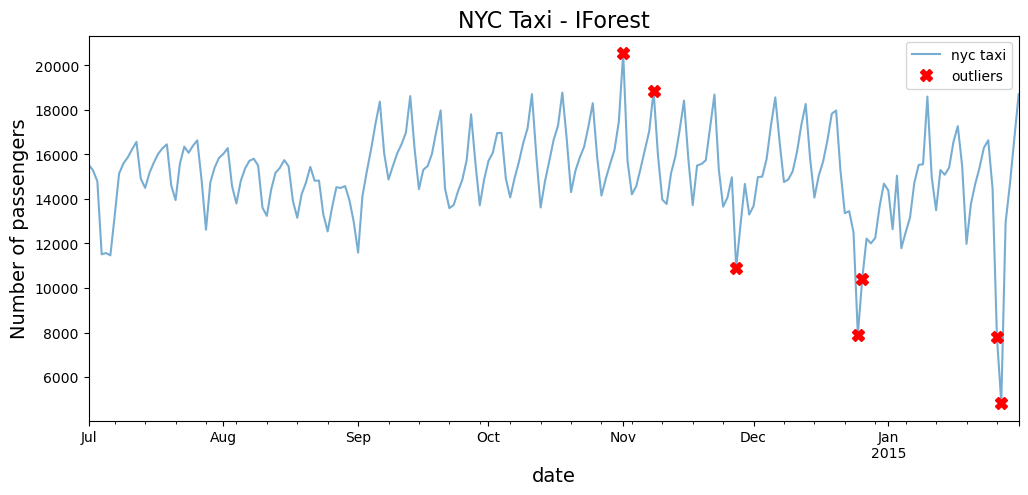

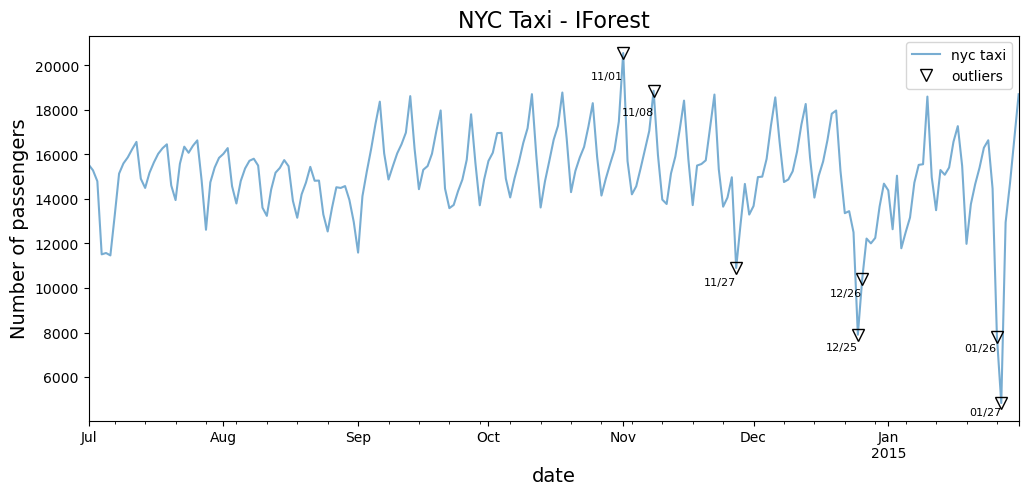

In [19]:
from pyod.models.iforest import IForest

iforest = IForest(contamination=0.03,
                 n_estimators=100)
iforest.fit(tx)

predicted = pd.Series(iforest.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
print(outliers)

plot_outliers(outliers, tx, 'IForest', name='fig14.6')

plot_outliers(outliers, 
              tx, 
              'IForest',
              labels=True)

In [20]:
iforest_scores = iforest.decision_scores_
iforest_scores_df = (pd.DataFrame(iforest_scores, 
             index=tx.index, 
             columns=['score']))
iforest_scores_df[iforest_scores_df['score'] >= iforest.threshold_].sort_values('score', ascending=False)



,score
timestamp,
2015-01-27,0.234167
2014-11-01,0.181933
2015-01-26,0.125143
2014-12-25,0.124627
2014-12-26,0.070310
2014-11-27,0.026948
2014-11-08,0.019019


In [21]:
### scikit leran verions of Isolation Forests
from sklearn.ensemble import IsolationForest

sk_iforest = IsolationForest(contamination=0.03)
sk_prediction = pd.Series(sk_iforest.fit_predict(tx), 
                      index=tx.index)
sk_outliers = sk_prediction[sk_prediction == -1]
sk_outliers = tx.loc[sk_outliers.index] 
sk_outliers


,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


###  Detecing Outliers using Copula-Based Outlier Detection (COPOD)

COPOD falls under probabilistic models and is labeled as a parameter-free algorithm. COPOD algo is vary fast and interpretable.

In time series forecasting, copulas have been used in univariate and multivariate forecasting, which is popular in financial risk modeling.

COPOD is an advanced algorithm, but it is still based on probabilistic modeling and finding statistically significant extremes within the data.


Number of outliers =  7
                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


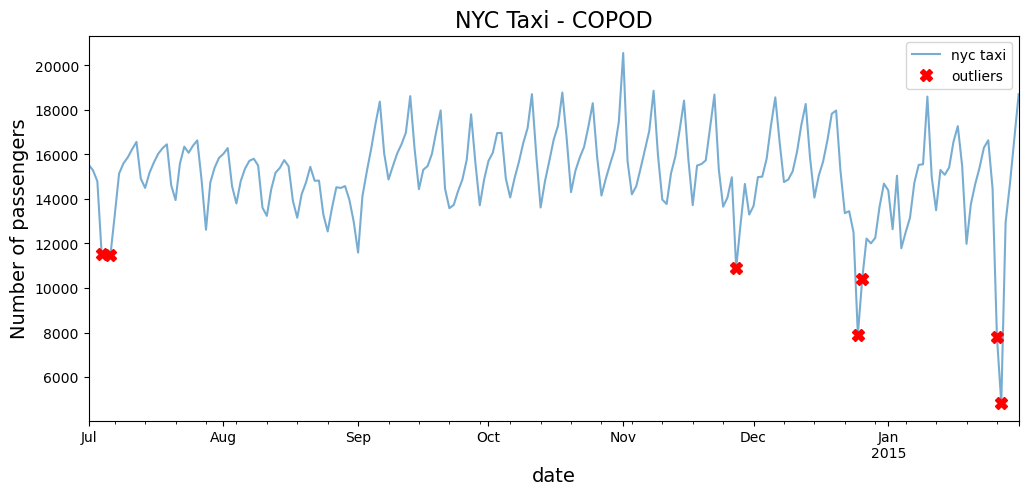

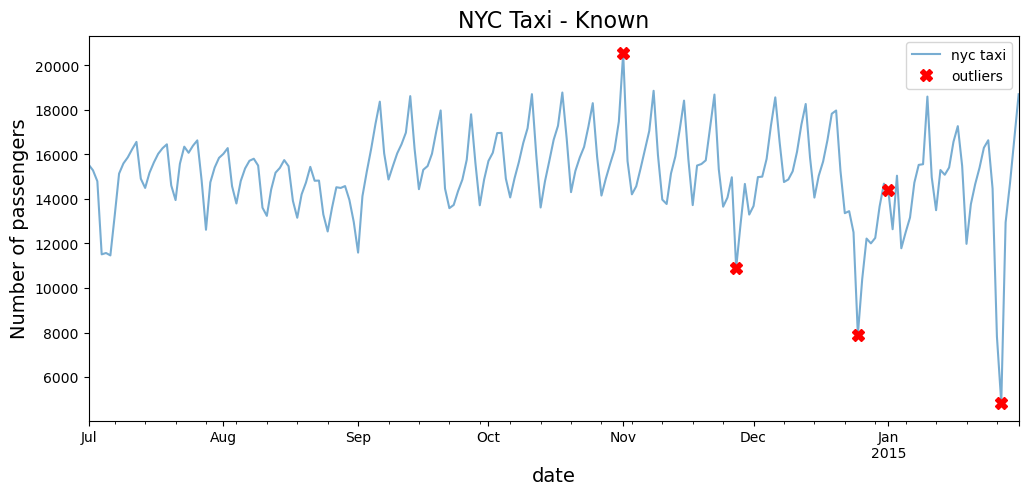

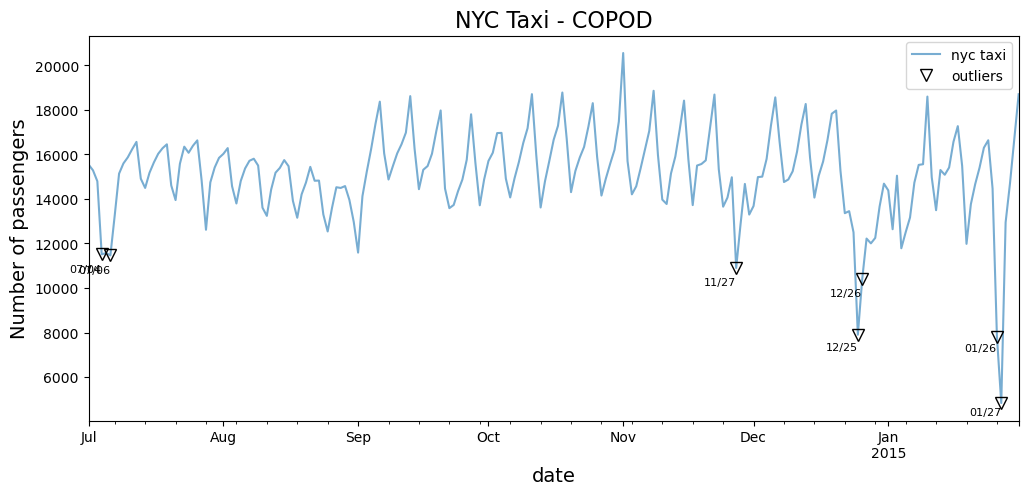

In [26]:
from pyod.models.copod import COPOD

copod = COPOD(contamination=0.03)
copod.fit(tx)

predicted = pd.Series(copod.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
print(outliers)

print(known_outliers)

plot_outliers(outliers, tx, 'COPOD', name='fig14.10')

plot_outliers(known_outliers, tx, 'Known')

plot_outliers(outliers, 
              tx, 
              'COPOD',
              labels=True)

#### Another simple and popular probabilistic algorithms is Median Absolute Deviation (MAD)

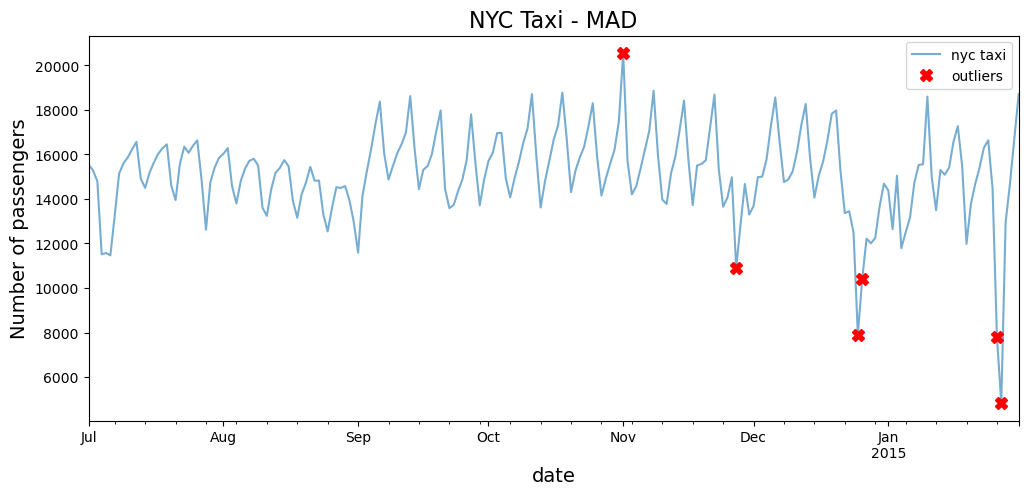

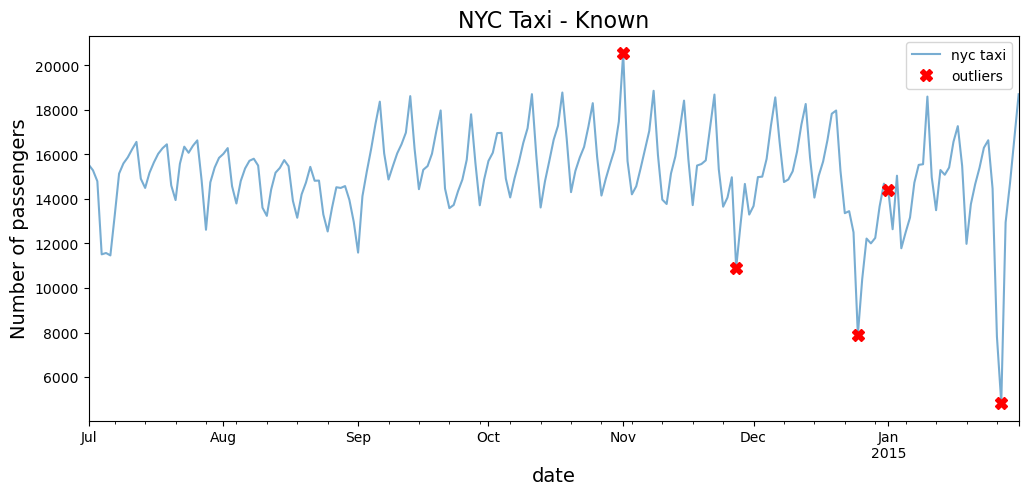

In [28]:
from pyod.models.mad import MAD

mad = MAD(threshold=3)

predicted = pd.Series(mad.fit_predict(tx), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 

plot_outliers(outliers, tx, 'MAD')

plot_outliers(known_outliers, tx, 'Known')

#### Another simple and popular probabilistic algorithms is LODA

Number of outliers =  6


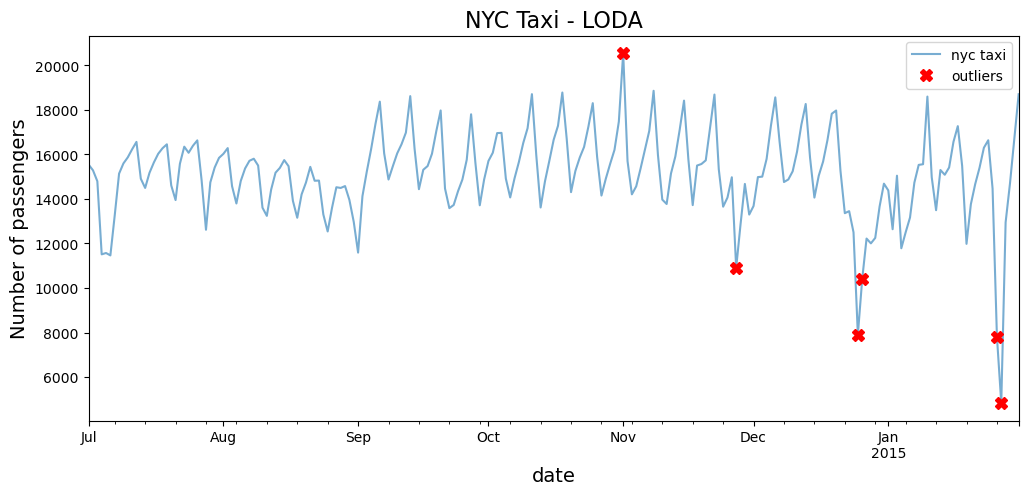

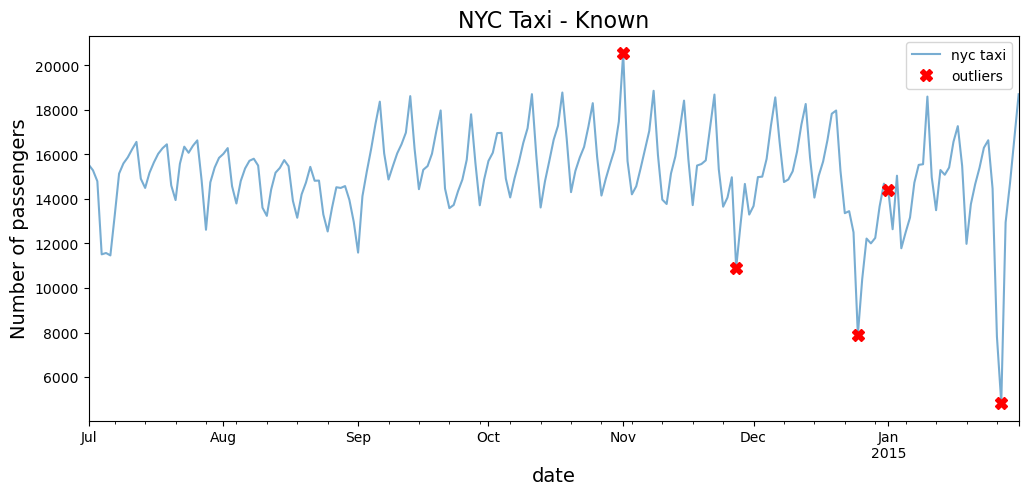

In [29]:
from pyod.models.loda import LODA

loda = LODA(contamination=0.03)
loda.fit(tx)

predicted = pd.Series(loda.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())     

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
outliers

plot_outliers(outliers, tx, 'LODA')
plot_outliers(known_outliers, tx, 'Known')


### Detecting Outliers using One Class SVM

Support Vector Machine (SVM) is a popular supervised machine learning algorithm that is mainly known for classification but can also be used for regression. The popularity of SVM comes from the use of kernel functions (sometimes referred to as the kernel trick), such as linear, polynomial, Radius-Based Function (RBF), and the sigmoid function.

The RBF kernel can capture non-linear relationships, so you would expect it to be a robust kernel.

You should scale the data when using OCSVM

Number of outliers =  5
                   value
timestamp               
2014-08-09  15499.708333
2014-11-18  15499.437500
2014-11-27  10899.666667
2014-12-24  12502.000000
2015-01-05  12502.750000
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


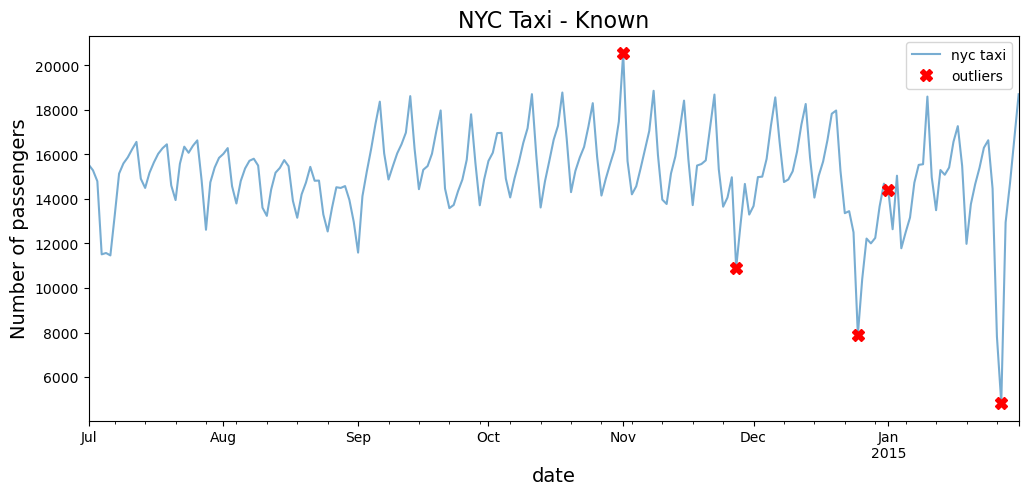

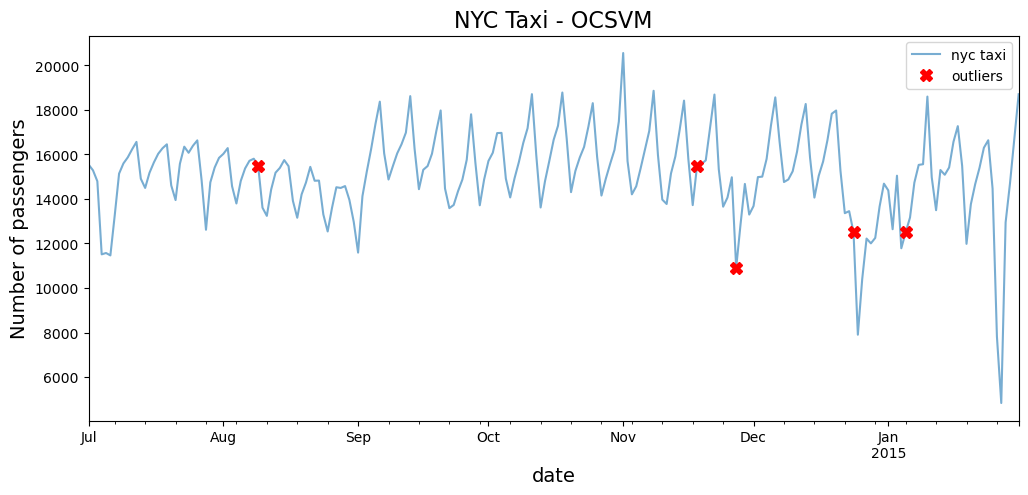

In [22]:
from pyod.models.ocsvm import OCSVM

ocsvm = OCSVM(contamination=0.03, kernel='rbf')
ocsvm.fit(tx)

predicted = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
print(outliers)

print(known_outliers)

plot_outliers(known_outliers, tx, 'Known')

plot_outliers(outliers, tx, 'OCSVM', name='fig14.7')



                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


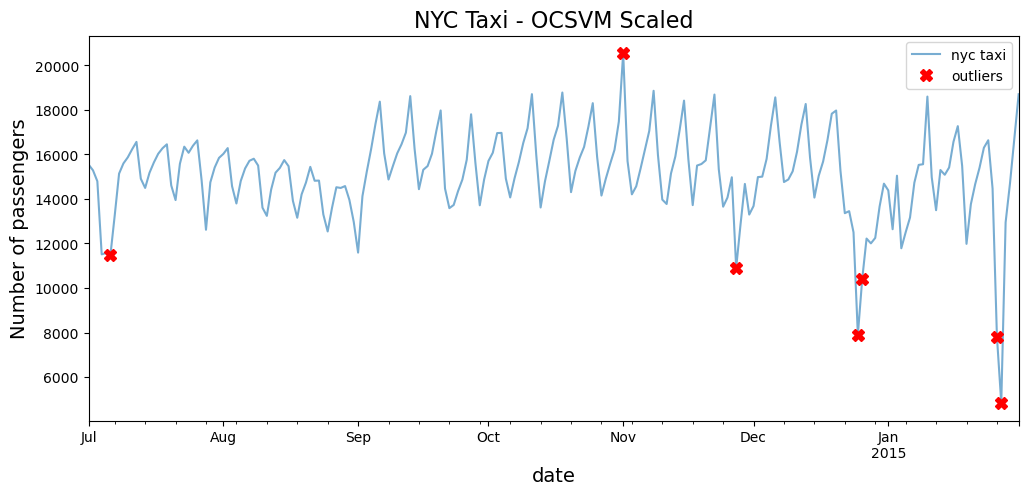

In [23]:
## The reason for this inaccuracy is that SVM is sensitive to data scaling

from pyod.utils.utility import standardizer
scaled = standardizer(tx)
predicted = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index)
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index] 
print(outliers)

plot_outliers(outliers, tx, 'OCSVM Scaled', name='fig14.8')



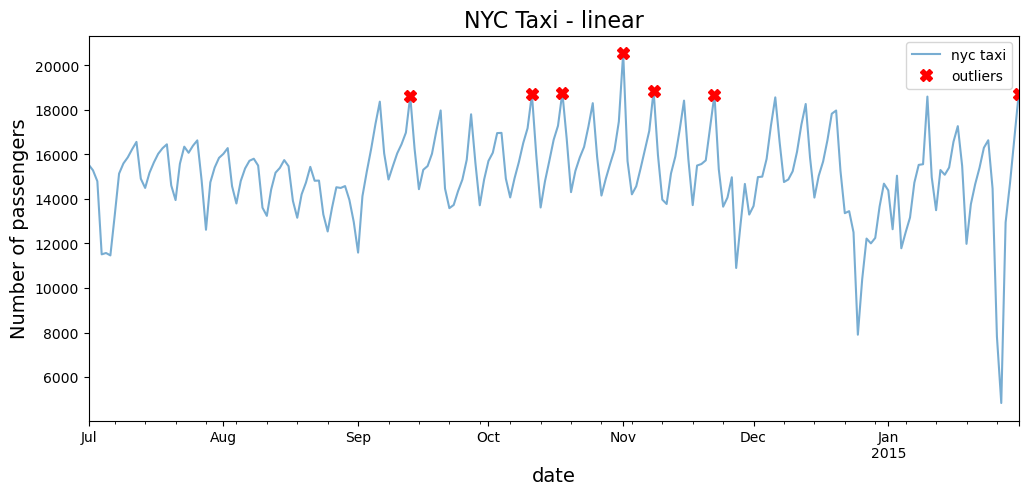

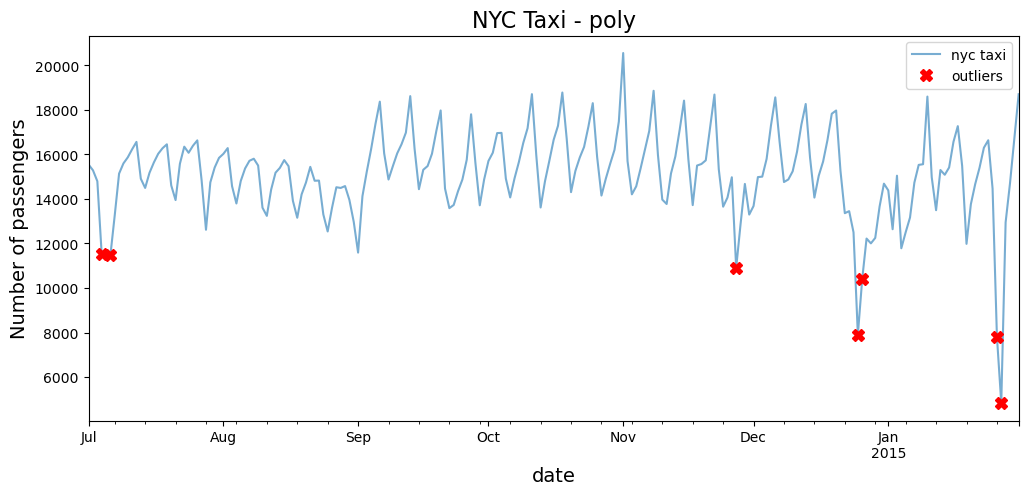

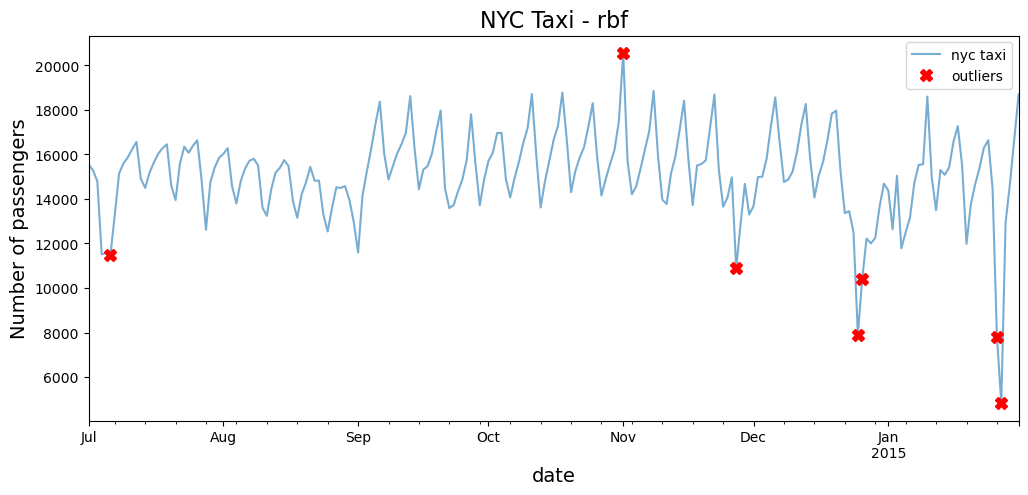

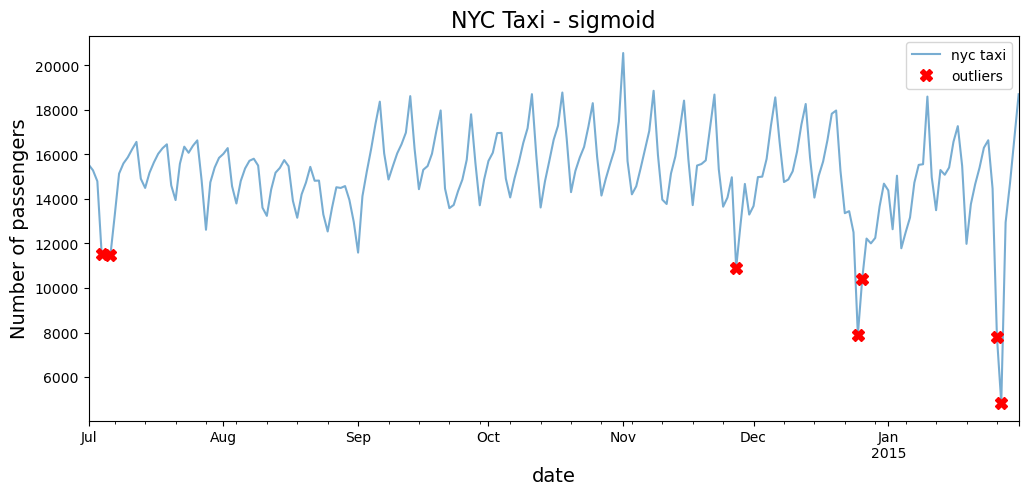

In [24]:
## use all kernals and best one based on scores

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, kernel=kernel)
    predict = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index, name=kernel)
    outliers = predict[predict == 1]
    outliers = tx.loc[outliers.index]
    plot_outliers(outliers, tx, kernel)